# Customer Clustering with KMeans to Boost Business Strategy
In this notebook it will be showned how to use the KMeans algorithm (unsupervised machine learning) to cluster customer data.


In [1]:
## Installing Required Libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

### Exploring the data

In [2]:
#Loading the data in a csv file into a dataframe.
df_sst = pd.read_csv('Wholesale customers data.csv')

#First five rows is showned
df_sst.head(5)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
print(df_sst.columns)

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')


In [4]:
#Showing the shape of the dataset.
df_sst.shape

(440, 8)

In [5]:
#Dropping columns 'Channel' and 'Region'
df_sst.drop(columns=['Channel', 'Region'], inplace= True)

### Creating a function for deciding which scaler is better according to the data distribution



In [6]:
def analyze_scaling_needs(data: pd.DataFrame):
    results = {}
    fig, axes = plt.subplots(len(data.columns), 3, figsize=(15, 5*len(data.columns)))
    
    # Calculating global x-axis limits
    global_min = min(data[col].min() for col in data.columns)
    global_max = max(data[col].max() for col in data.columns)
    x_range = (global_min, global_max)
    
    for idx, column in enumerate(data.columns):
        values = data[column].values
        
        # 1. Checking outliers
        q1 = np.percentile(values, 25)
        q2 = np.percentile(values, 50)  # median
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        outlier_bounds = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
        outliers = np.sum((values < outlier_bounds[0]) | (values > outlier_bounds[1]))
        
        # 2. Test for normality - fixing the unpacking
        statistic, normality_p_value = stats.normaltest(values)
        
        # 3. Check value range
        value_range = values.max() - values.min()
        
        # Histogram with percentile lines
        sns.histplot(data, x=column, ax=axes[idx, 0])
        axes[idx, 0].axvline(q1, color='r', linestyle='--', label=f'25th: {q1:.2f}')
        axes[idx, 0].axvline(q2, color='g', linestyle='--', label=f'50th: {q2:.2f}')
        axes[idx, 0].axvline(q3, color='b', linestyle='--', label=f'75th: {q3:.2f}')
        axes[idx, 0].set_title(f'{column} Distribution')
        axes[idx, 0].set_xlim(x_range)
        axes[idx, 0].legend()
        
        
        # Box plot
        sns.boxplot(data, x=column, ax=axes[idx, 1])
        axes[idx, 1].set_title(f'{column} Box Plot')
        axes[idx, 1].set_xlim(x_range)
        
        # Q-Q plot
        stats.probplot(values, dist="norm", plot=axes[idx, 2])
        axes[idx, 2].set_title(f'{column} Q-Q Plot')
        
        # Storing analysis results
        results[column] = {
            'has_outliers': outliers > 0,
            'outlier_count': outliers,
            'is_normal': normality_p_value > 0.05,
            'value_range': value_range,
            'skewness': stats.skew(values),
            'percentiles': {
                '25th': q1,
                '50th': q2,
                '75th': q3
            }
        }
    
    plt.tight_layout()
    plt.show()
    
    # Print recommendations and percentiles
    print("\nScaling Recommendations:")
    print("-----------------------")
    for column in data.columns:
        print(f"\nColumn: {column}")
        r = results[column]
        
        print(f"Percentiles:")
        print(f"  25th: {r['percentiles']['25th']:.2f}")
        print(f"  50th: {r['percentiles']['50th']:.2f}")
        print(f"  75th: {r['percentiles']['75th']:.2f}")
        
        if r['has_outliers'] and r['outlier_count'] > len(data.columns) * 0.01:
            print("✓ RobustScaler recommended due to significant outliers")
        
        if r['is_normal']:
            print("✓ StandardScaler suitable due to normal distribution")
        
        if r['value_range'] > 10:
            print("✓ MinMaxScaler could be useful for large value ranges")
            
        if abs(r['skewness']) > 2:
            print("✓ Consider log transformation before scaling")
    
    return results

In [7]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_sst)

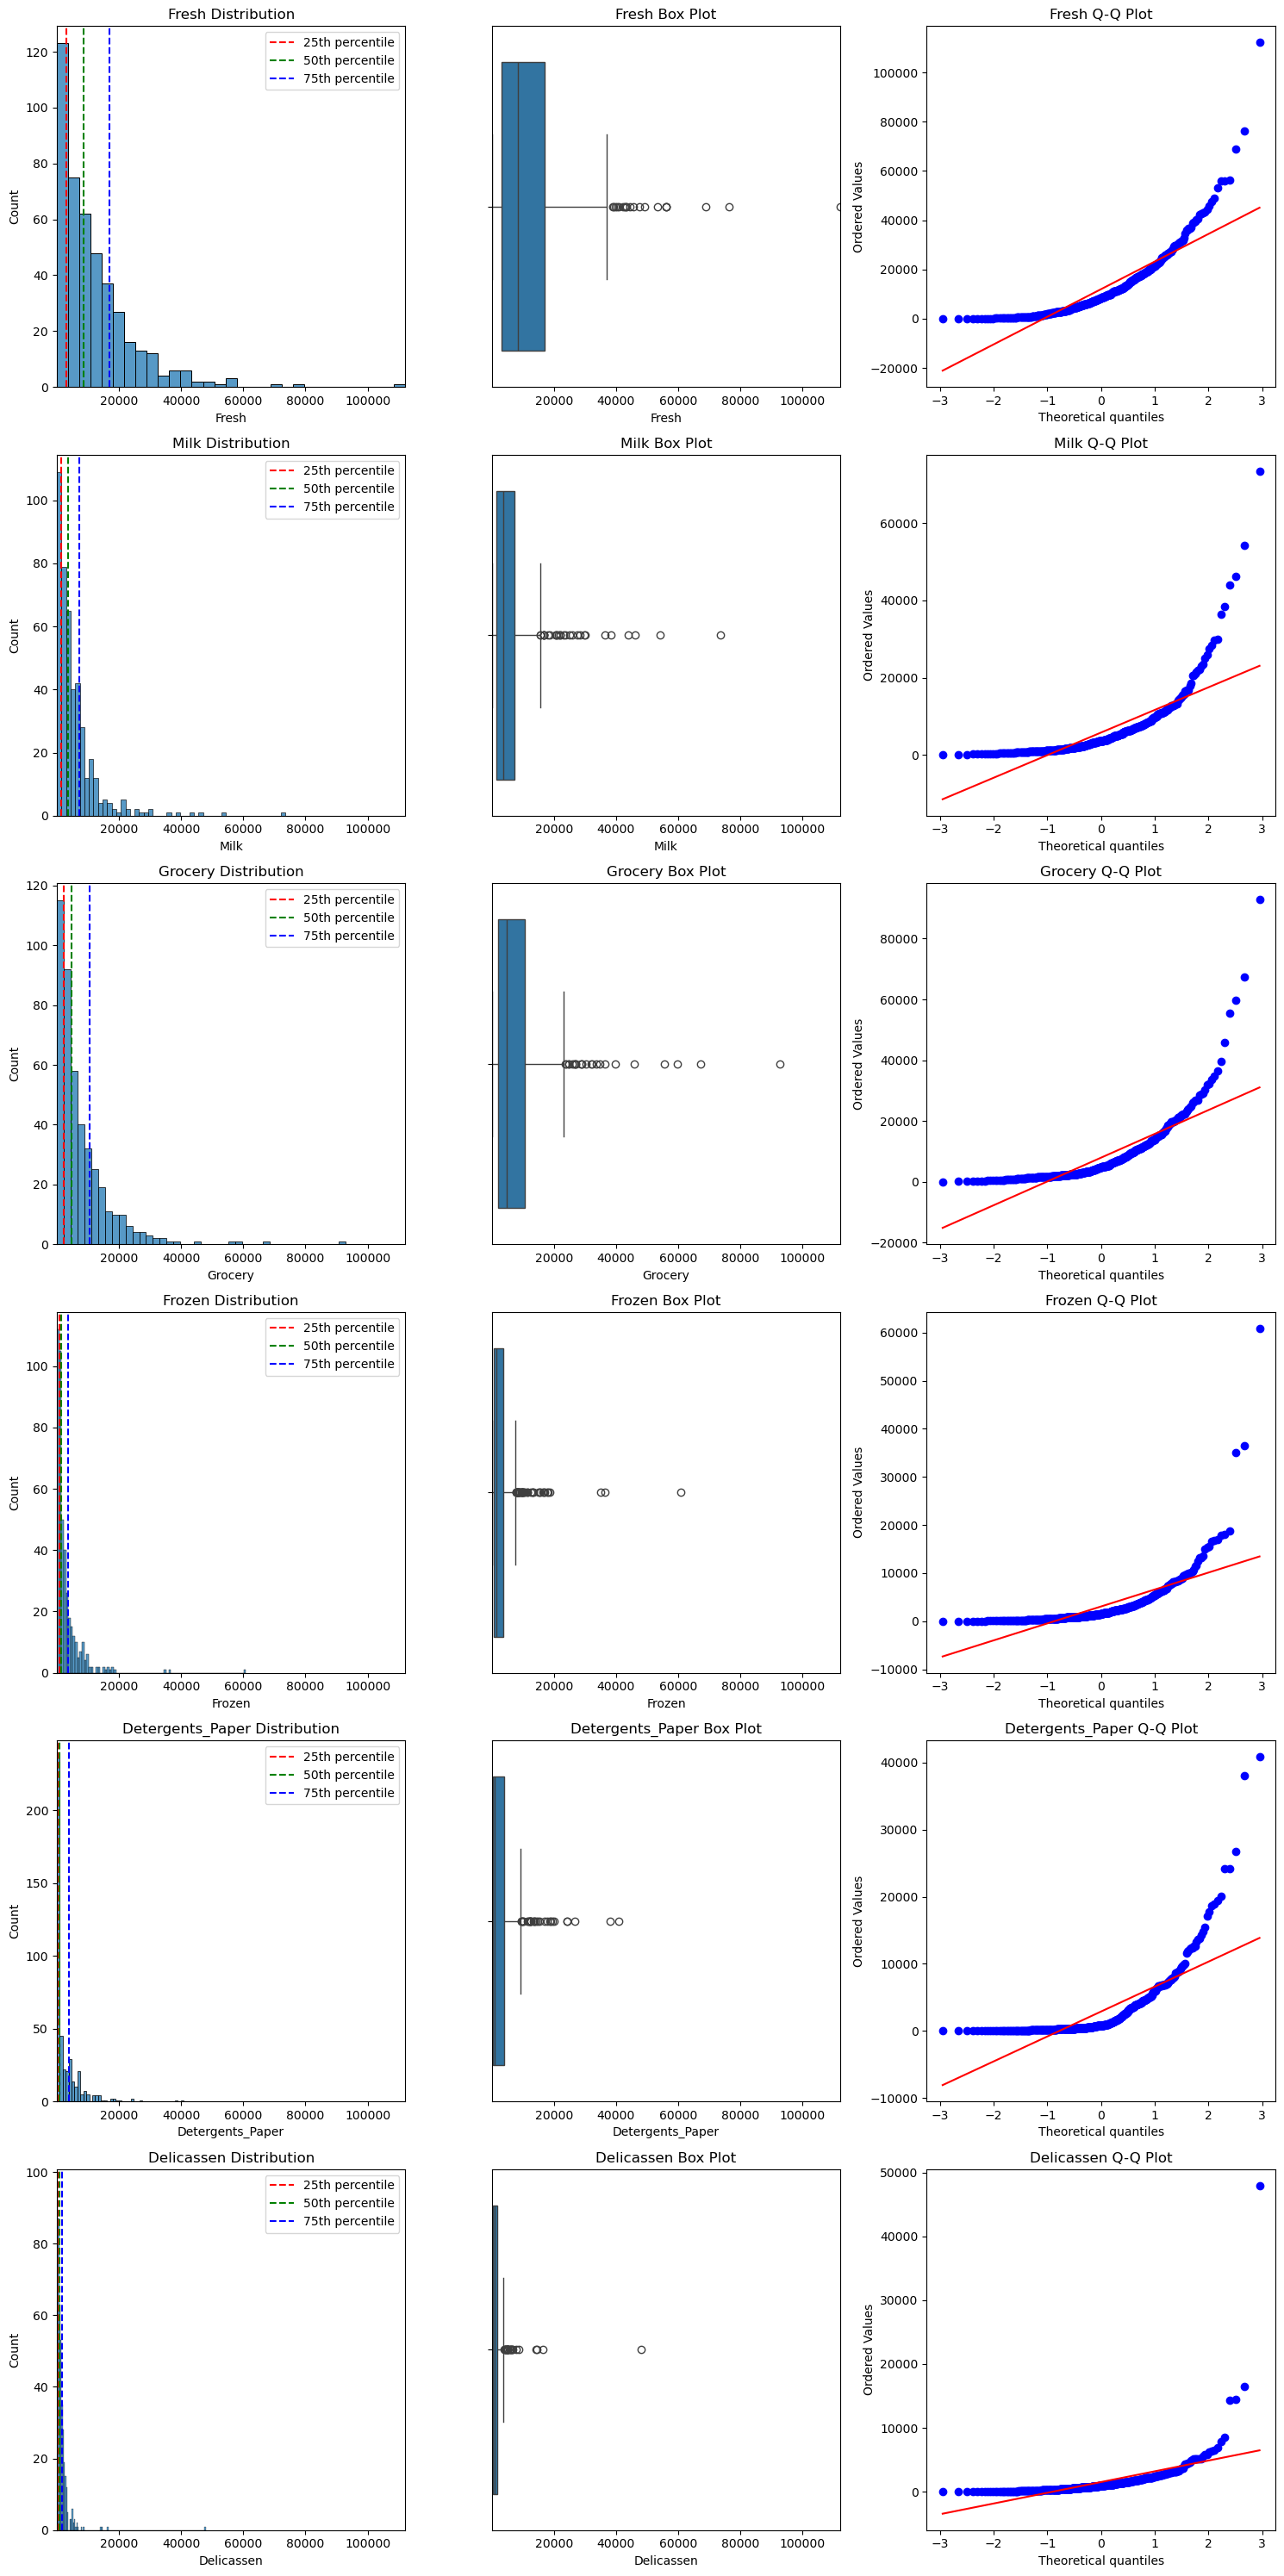


Scaling Recommendations:
-----------------------

Column: Fresh
Percentiles:
  25th: 3127.75
  50th: 8504.00
  75th: 16933.75
✓ RobustScaler recommended due to significant outliers
✓ MinMaxScaler could be useful for large value ranges
✓ Consider log transformation before scaling

Column: Milk
Percentiles:
  25th: 1533.00
  50th: 3627.00
  75th: 7190.25
✓ RobustScaler recommended due to significant outliers
✓ MinMaxScaler could be useful for large value ranges
✓ Consider log transformation before scaling

Column: Grocery
Percentiles:
  25th: 2153.00
  50th: 4755.50
  75th: 10655.75
✓ RobustScaler recommended due to significant outliers
✓ MinMaxScaler could be useful for large value ranges
✓ Consider log transformation before scaling

Column: Frozen
Percentiles:
  25th: 742.25
  50th: 1526.00
  75th: 3554.25
✓ RobustScaler recommended due to significant outliers
✓ MinMaxScaler could be useful for large value ranges
✓ Consider log transformation before scaling

Column: Detergents_Paper
P

In [8]:
columns_to_analyze = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
results = analyze_scaling_needs(df_sst)


### Deciding how many clusters to create using "Elbow method"

In [ ]:
# Standardize the features
scaler = RobustScaler()
# Convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df_sst), columns=df_sst.columns)

# Calculate inertia for different numbers of clusters
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10,6), dpi=100)
plt.plot(range(2,10), inertia, marker="o", color="aquamarine")
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Inertia", fontsize=12)
plt.title("Elbow Method for Optimal k", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In conclution our k for the model is 4.

In [ ]:


# Standardize the features (reusing your existing scaler)
scaler = RobustScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_sst), columns=df_sst.columns)

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
K = range(2, 10)

for k in K:
    # Create and fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    
    # Calculate silhouette score
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(K, silhouette_scores, marker='o', color='purple')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Analysis for Optimal k', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Add score labels on the points
for i, score in enumerate(silhouette_scores):
    plt.annotate(f'{score:.3f}', 
                (K[i], score),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.show()

# Print the optimal k based on highest silhouette score
optimal_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Maximum silhouette score: {max(silhouette_scores):.3f}")

### Using KMeans

In [36]:
number_of_clusters = 4

In [37]:
#Create a KMeans clustering model.
cluster = KMeans(n_clusters = number_of_clusters)

#Determing the value of the parameter 'n_init' for future changes 
kmeans = KMeans(n_init='auto')

In [ ]:
#Training the model. 
result = cluster.fit_transform(df_sst)

In [ ]:
#Cluster centers are printed.
cluster.cluster_centers_

### Creating a function for plotting cluster centers of the dataset

In [ ]:
# For multiple features we use PCA to visualize in 2D
def plot_clusters_pca(data, cluster_model):
    
    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centers_2d = pca.transform(cluster_model.cluster_centers_)
    
    # Creating the plot
    plt.figure(figsize=(10, 6))
    
    # Plotting the data points
    scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], 
                         c=cluster_model.labels_, cmap='viridis')
    
    # Plot the cluster centers
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
               c='red', marker='x', s=200, linewidths=3, 
               label='Cluster Centers')
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Cluster Centers and Data Points (PCA)')
    plt.legend()
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()


plot_clusters_pca(df_sst, cluster)

### Making Predictions

In [ ]:
#Ckecking columns name.
df_sst.columns.tolist()

In [ ]:
#Making predictions and saving them into the column "cluster_number".
df_sst['cluster_number'] = cluster.predict(df_sst)
df_sst.sample(5)

In [ ]:
#Printing the cluster numbers and the number of customers in each cluster.
df_sst.cluster_number.value_counts()

In [52]:
#TODO usar reducción de dimensionalidad, por ejemplo el PSA

#Investigar el método de la silueta